In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns

slim = tf.contrib.slim
ds = tf.contrib.distributions
from universal_divergence import estimate
from utils import nn_l2_mean

from functools import reduce
from operator import mul


import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Populating the interactive namespace from numpy and matplotlib



### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [2]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [3]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [4]:
params = dict(
    batch_size=512,
    disc_learning_rate=9e-5,
    gen_learning_rate=9e-5,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=8000,
    viz_every=500,
    z_dim=256,
    x_dim=2,
    optimizer='sga', # rmsprop sgd sga
    alignement=True
)

## Function for Symplectic gradient adjustment

In [5]:
def jac_vec(ys,xs,vs):
    return fwd_gradients(ys,xs,grad_xs=vs, stop_gradients=xs)

def jac_tran_vec(ys,xs,vs):
    dydxs = tf.gradients(ys,xs,grad_ys=vs, stop_gradients=xs)
    return [tf.zeros_like(x) if dydx is None else dydx for (x,dydx) in zip(xs,dydxs)]

def get_sym_adj(Ls,xs):
    xi= [tf.gradients(l,x)[0]for(l,x)in zip(Ls,xs)]
    H_xi = jac_vec(xi,xs,xi)
    Ht_xi = jac_tran_vec(xi,xs,xi)
    At_xi =[(ht-h)/2 for (h,ht) in zip(H_xi,Ht_xi)]
    return At_xi

## Construct model and training ops

In [6]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.2)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group([d_train_op, g_train_op])

    
elif params['optimizer'] == 'sga': 
    print('sga enabled ...')
    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])

    dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
    gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)

    adj = get_sym_adj([loss]*len(disc_vars) + [-loss]*len(gen_vars),disc_vars+gen_vars)
    d_adj= adj[:len(disc_vars)]
    g_adj = adj[-len(gen_vars)::]
    
    dvs_sga = [(grad + adj , var) for (grad,var),adj in zip(dvs,d_adj)]
    gvs_sga = [(grad + adj , var) for (grad,var),adj in zip(gvs,g_adj)]
    
    d_train_op = d_opt.apply_gradients(dvs_sga)
    g_train_op = g_opt.apply_gradients(gvs_sga)
    train_op = tf.group([d_train_op, g_train_op])

elif params['optimizer'] == 'sga_align':
    print('sga align ...')
    epsilon = 1/10
    optimizer = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])

    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    grads = d_grads + g_grads
    variables = disc_vars + gen_vars

    at_xi = get_sym_adj([loss]*len(disc_vars) + [-loss]*len(gen_vars),disc_vars+gen_vars)

    ######### alignment ##########
    reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
    nabla_h = tf.gradients(reg, variables)
    p_scal_1 = sum([tf.reduce_sum(tf.multiply(xi,h)) for (xi,h) in zip(grads,nabla_h)])   
    p_scal_2 = sum([tf.reduce_sum(tf.multiply(at_xi,h)) for (at_xi,h) in zip(at_xi,nabla_h)])

    d = sum([reduce(mul,x.get_shape().as_list()) for x in variables]) # multiply dim arrays and sum to get nb of parameters

    _lambda = tf.sign((1/d) * p_scal_1 * p_scal_2 + epsilon)
#     _lambda = tf.constant(1.)
    apply_vec = [(grad + _lambda * _at_xi, w) for (grad,_at_xi,w) in zip(grads, at_xi, variables)]

    #         with tf.control_dependencies([g for (g, v) in apply_vec]):
    train_op = optimizer.apply_gradients(apply_vec)    
else:
    raise NotImplementedError
    

sga enabled ...


## Train

In [7]:
# config = tf.ConfigProto(device_count={'GPU': 0})
# config.gpu_options.allow_growth = True

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/8001 [00:00<?, ?it/s]

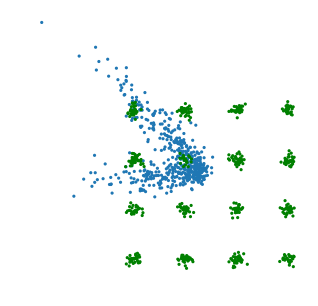

  6%|▌         | 471/8001 [00:41<10:55, 11.48it/s]

In [ ]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']

nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
for i in tqdm(range(params['max_iter']+1)):
    f, _ = sess.run([[loss], train_op])
    fs.append(f)
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
        axis('off')
        show()
        
#     if (i) % nn_every == 0:
#         x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
#         l2nn = nn_l2_mean(x,y_ref)
#         kl =estimate(x, y_ref,k=1)
#         nn_dist.append(l2nn)
#         nn_kl.append(kl)    

In [ ]:
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm', n_levels=20, clip=[[-6,6]]*2,bw=.30)
#     ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
gcf().tight_layout()

In [ ]:
plt.semilogy(nn_dist)
plt.semilogy(nn_kl)
plt.legend(['kl','l2 nearest neigbhors'])
xlabel('iterations')
plt.show()

In [ ]:
# nn_con=np.load('nndist.npy')
# kl_con = np.load('kldist.npy')

In [ ]:
# plt.semilogy(nn_dist)
# plt.semilogy(nn_kl)
# plt.semilogy(kl_con)
# plt.semilogy(nn_con)
# plt.legend(['kl SGA','l2 NN SGA','l2 NN Concensus','kl Concensus'],loc='upper right')
# xlabel('iterations')
# plt.show()

In [ ]:
np.save('plot_sgd_kl',nn_kl)
np.save('plot_sgd_nn',nn_dist)